# Lab 8 - Aspect-Based Sentiment Analysis with BERT

In this lab we turn a pre-trained BERT model into a trainable Keras layer and apply it to the Aspect-Based Sentiment Analysis that we tackled in lab 4. BERT (Bidirectional Embedding Representations from Transformers) is a new model for pre-training language representations that obtains state-of-the-art results on many NLP tasks. We demonstrate how to integrate BERT as a custom Keras layer to simplify model prototyping using huggingface. In this lab, you will learn: 

1) How to use the huggingface package.

2) How to integrate BERT in our previous model. 

3) How to use the TPU from Colab. (Note: Running BERT on the CPU would be very slow. Thus we recommend you to do this lab on Colab based on TPU provided by Google.)

In [ ]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model


Before start, we should install the huggingface transformer package. You can find the doc from its [website](https://huggingface.co/transformers/index.html).

In [ ]:
pip install transformers

## Preprocessing and Tokenization

In this lab we will use DistilBERT instead of BERT: DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, and runs 60% faster, while preserving over 95% of BERT’s performance as measured on the GLUE language understanding benchmark.

It is easy to switch between DistilBERT and BERT using the huggingface transformer package. This huggingface package provides many pre-trained and pre-built models that are easy to use via a few lines of code.

Before using DistilBERT or BERT, we need a tokenizer. Generally speaking, every BERT related model has its own tokenizer, trained for that model (see this week's lecture video on sub-word tokenization). 
We can get the DistilBERT tokenizer from **DistilBertTokenizer.from_pretrained** function.

In [ ]:
from transformers import DistilBertTokenizer, RobertaTokenizer 
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


Then we can use the tokenizer to tokenize the sentence. When working with word2vec and GloVe, we tokenized the sentence into words ourselves and then converted the tokens to GloVe word indices. But in BERT, we must use the BERT tokenizer: the tokens for BERT are different, and include whole words and sub-word tokens (see lecture video on sub-word tokenisation).

For example, for the sentence: **This is a pretrained model.** our previous word-based tokenizer will generate the following tokens:

**"this", "is", "a", "pretrained", "model", "."**

Then you will find out that the word token "pretrained" is not in the GloVe word dictionary. Thus we can not assign a proper word vector for "pretrained".

In BERT, the BERT tokenizer will separate the word "pretrained" into three sub-word tokens:

**'pre', '##train', '##ed'**

This way, BERT can use these three token vectors to represent the word "pretrained". Without the BERT tokenizer, it is hard to separate these unknown words properly.

You will also see that the BERT tokenizer adds the special sentence [CLS] token and sentence separator [SEP] tokens (see this week's lecture videos).

In [ ]:
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')

inputs = tokenizer.tokenize("This is a pretrained model.")
print(inputs,'\n')

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, pad_to_max_length=False)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 

['this', 'is', 'a', 'pre', '##train', '##ed', 'model', '.'] 

[ 101 1996 3007 1997 2605 2003  103 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Loading Data

### Downloading and preprocessing data

Similar to lab 4, we need to download and preprocess the data first. The data download code is consistent with lab 4.

In [ ]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
dev = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))
print("Dev entries: {}".format(len(dev)))

Training entries: 11186
Test entries: 1336
Dev entries: 1332


We now can start playing around with the data, let’s first see some examples:

In [ ]:
print("SENTENCE \t ASPECT \t LABEL \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABEL 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


According to the BERT tokenize function above, we can convert the tweet text and topic words to integers:

(Note: the BERT tokenize function is different from lab 4.)


In [ ]:
# Please write your code to generate the following data
x_train_review_int = []
x_train_review_masks = []
x_train_aspect_int = []
x_train_aspect_masks = []

x_dev_review_int = []
x_dev_review_masks = []
x_dev_aspect_int = []
x_dev_aspect_masks = []

x_test_review_int = []
x_test_review_masks = []
x_test_aspect_int = []
x_test_aspect_masks = []


#######################TODO: REMOVE FOLLOWING CODE####################
for sample in train:
    id, masks, seg = tokenize(sample[0], tokenizer)
    id_aspect, mask_aspect, seg_aspect = tokenize(sample[1], tokenizer, pad_to_max_length=False)
    x_train_review_int.append(id)
    x_train_review_masks.append(masks)
    x_train_aspect_int.append(id_aspect)
    x_train_aspect_masks.append(mask_aspect)

for sample in dev:
    id, masks, seg = tokenize(sample[0], tokenizer)
    id_aspect, mask_aspect, seg_aspect = tokenize(sample[1], tokenizer)
    x_dev_review_int.append(id)
    x_dev_review_masks.append(masks)
    x_dev_aspect_int.append(id_aspect)
    x_dev_aspect_masks.append(mask_aspect)


for sample in test:
    id, masks, seg = tokenize(sample[0], tokenizer)
    id_aspect, mask_aspect, seg_aspect = tokenize(sample[1], tokenizer)
    x_test_review_int.append(id)
    x_test_review_masks.append(masks)
    x_test_aspect_int.append(id_aspect)
    x_test_aspect_masks.append(mask_aspect)

# some doubts here remember to check again

# If use the previous tokenize function, you can get a print result like:
assert len(x_train_aspect_int) == len(train)
assert len(x_train_aspect_masks) == len(x_train_aspect_int)
assert len(x_test_aspect_int) == len(test)
assert len(x_test_aspect_masks) == len(x_test_aspect_int)
print("x_dev_aspect_int[0]:")
print(x_dev_aspect_int[0])
print("x_dev_aspect_masks[0]:")
print(x_dev_aspect_masks[0])
print("x_dev_review_int[0]:")
print(x_dev_review_int[0])
print("x_dev_review_masks[0]:")
print(x_dev_review_masks[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


x_dev_aspect_int[0]:
[ 101 8974  102    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
x_dev_aspect_masks[0]:
[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_dev_review_int[0]:
[  101  2044  1037  323

We one-hot encode the labels, using 4 (Binary:100) to represent "positive", 2 (Binary:010) for "neutral", and 1 (Binary:001) for "negative". Then we can convert the labels to numbers.

In [ ]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y
  
y_train = label2int(train)
y_dev = label2int(dev)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost done the data preprocessing. Unlike the previous lab1-lab4, there are two x (review and aspect) to input the model. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

In [ ]:
x_train_int = []
x_train_masks = []
x_dev_int = []
x_dev_masks = []
x_test_int = []
x_test_masks = []

# Tips: 
# 1) We can use the special token <SEP> to concatenate the tweets and topics.
# 2) After combine them, make sure they are paded.

for sample in train: 
    id, mask, _ = tokenize(sample[0]+' '+ tokenizer.sep_token+' '+ sample[1], tokenizer)
    x_train_int.append(np.array(id))
    x_train_masks.append(np.array(mask))


for sample in dev: 
    id, mask, _ = tokenize(sample[0]+' '+ tokenizer.sep_token+' '+ sample[1], tokenizer)
    x_dev_int.append(np.array(id))
    x_dev_masks.append(np.array(mask))


for sample in test: 
    id, mask, _ = tokenize(sample[0]+' '+ tokenizer.sep_token+' '+ sample[1], tokenizer)
    x_test_int.append(np.array(id))
    x_test_masks.append(np.array(mask))



# Don't forget the to use np.array function to wrap the ouput of pad_sequences function
x_train_int_np = np.array(x_train_int)
x_train_masks_np = np.array(x_train_masks)
x_dev_int_np = np.array(x_dev_int)
x_dev_masks_np = np.array(x_dev_masks)
x_test_int_np = np.array(x_test_int)
x_test_masks_np = np.array(x_test_masks)


print(x_dev_int[0])
print(x_dev_masks[0],'\n')
print(x_dev_int_np[0])
print(x_dev_masks_np[0]) # senetnce + aspect


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[  101  2044  1037  3232  1997  8974  1010  1996 18726  1011  1011  1045
  2066  1996 27940  1013 24792  2621  4897  1998  1996 13675 11514  6508
 26852  1011  1011  2175  2091  2307  1012   102  8974   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

<font color = "#5a5f70"><b> In the above code we have passed each review and aspect to into the BERT Tokenize function. Along with that we also passed the Distillbert tokenizer object that we created earlier. We can pass either pad_to_max_length as False or True depending on our need( In this case to True). This tokenizer function returns us 3 things - The IDs, segments and masks. We then appended the ids and mask returned into our separate lists. This was done for all 3 sets - training, testing and validation. Since we are using reviews and aspects altogether, we need to concatinate them and add a \[SEP] so that in the tockenizer they are not mixed without a certain seperator. The tokenization function automatically can do the post padding therefore there is no need for more padding</b>  </font>

In [ ]:
#examples of <SEP> injected to the examples
print(tokenizer.convert_ids_to_tokens(x_train_int[0]),"\n")
print(tokenizer.convert_ids_to_tokens(x_dev_int[0]),"\n")
print(tokenizer.convert_ids_to_tokens(x_test_int[0]),"\n")


['[CLS]', 'the', 'decor', 'is', 'not', 'special', 'at', 'all', 'but', 'their', 'food', 'and', 'amazing', 'prices', 'make', 'up', 'for', 'it', '.', '[SEP]', 'decor', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

## Model 1: Prebuilt Sequence Classification



The huggingface transformer package provides many prebuilt models. Now let us try a sequence classification model based on distillBERT. 

The models with BERT are much bigger than our previous models. To run it faster, we can use TPU here. The detailed guideline about using TPU can be found from https://www.tensorflow.org/guide/tpu.

In [ ]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(num_labels=3)
config.output_hidden_states = False

def create_TFDistilBertForSequenceClassification():
  transformer_model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFDistilBertForSequenceClassification()
    optimizer = tf.keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model = create_TFDistilBertForSequenceClassification()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.119.127.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.127.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_c

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955779   ['input_token[0][0]',            
 assification_1 (TFDistilBertFo  rOutput(loss=None,               'masked_token[0][0]']           
 rSequenceClassification)       logits=(None, 3),                                                 
                                 hidden_states=None                                         

In [ ]:
history = model.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 109s 3s/step - loss: 0.7713 - accuracy: 0.4328 - val_loss: 0.5940 - val_accuracy: 0.4557
Epoch 2/30
22/22 [==============================] - 5s 210ms/step - loss: 0.5954 - accuracy: 0.4716 - val_loss: 0.6012 - val_accuracy: 0.4272
Epoch 3/30
22/22 [==============================] - 5s 211ms/step - loss: 0.5683 - accuracy: 0.5106 - val_loss: 0.5196 - val_accuracy: 0.6194
Epoch 4/30
22/22 [==============================] - 5s 211ms/step - loss: 0.5079 - accuracy: 0.6412 - val_loss: 0.5277 - val_accuracy: 0.6817
Epoch 5/30
22/22 [==============================] - 5s 211ms/step - loss: 0.4431 - accuracy: 0.6954 - val_loss: 0.5180 - val_accuracy: 0.5698
Epoch 6/30
22/22 [==============================] - 5s 212ms/step - loss: 0.4603 - accuracy: 0.7104 - val_loss: 0.4621 - val_accuracy: 0.7545
Epoch 7/30
22/22 [==============================] - 5s 210ms/step - loss: 0.3683 - accuracy: 0.7942 - val_loss: 0.4285 - val_accuracy: 0.7800
Epoch 8

In [ ]:
results = model.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results)

42/42 [==============================] - 8s 101ms/step - loss: 0.8380 - accuracy: 0.8069
[0.8380170464515686, 0.8068862557411194]


In [ ]:
! pip install plot_keras_history


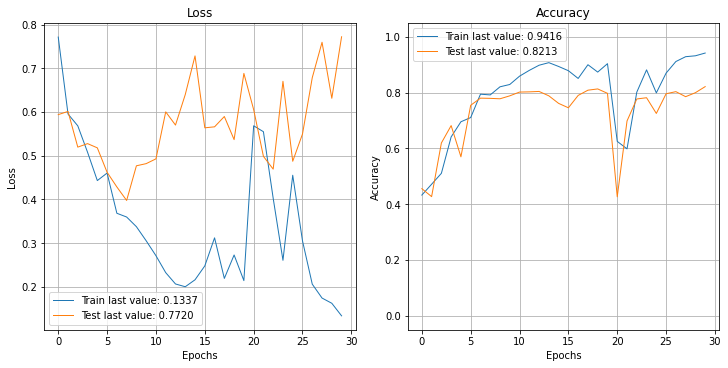

In [ ]:
from plot_keras_history import plot_history
plot_history(history.history, path="std.png")
plt.show()

<font color = "#5a5f70"><b>This model has 80% accuracy which is still greater than any model done in Lab 4. In Lab 4 we use Glove word embeddings while here we are using BERT. The main difference between them is that the words in word embeddings are independent of context. However a BERT is backed by a transformer and its main feature which is attention. This helps the model understand the contextual relationship between words. This helps this model get more accuracy compared to the models in Lab 4. I think we can still improve it for out task if we make embeddigs trainable but there is a huge computation cost awaiting us should we decide to do so.</b></font>


## Model 2: Neural bag of words using BERT

We use model3-1 from lab4 to integrate BERT, using BERT instead of the previous static word embeddings.


In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model2 = create_bag_of_words_BERT()
    optimizer2 = tf.keras.optimizers.Adam(lr=5e-5)
    model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model2 = create_bag_of_words_BERT()
  model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary() 




INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.119.127.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.127.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model2_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_11 (TFDis  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 tilBertModel)                  ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

history = model2.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 109s 3s/step - loss: 0.6278 - accuracy: 0.4624 - val_loss: 0.5850 - val_accuracy: 0.5203
Epoch 2/30
22/22 [==============================] - 5s 219ms/step - loss: 0.5539 - accuracy: 0.5729 - val_loss: 0.5144 - val_accuracy: 0.6584
Epoch 3/30
22/22 [==============================] - 5s 219ms/step - loss: 0.4991 - accuracy: 0.6719 - val_loss: 0.4753 - val_accuracy: 0.7222
Epoch 4/30
22/22 [==============================] - 5s 218ms/step - loss: 0.4569 - accuracy: 0.7523 - val_loss: 0.4433 - val_accuracy: 0.7778
Epoch 5/30
22/22 [==============================] - 6s 259ms/step - loss: 0.4239 - accuracy: 0.8091 - val_loss: 0.4329 - val_accuracy: 0.7898
Epoch 6/30
22/22 [==============================] - 5s 219ms/step - loss: 0.4015 - accuracy: 0.8443 - val_loss: 0.4269 - val_accuracy: 0.8003
Epoch 7/30
22/22 [==============================] - 5s 219ms/step - loss: 0.3869 - accuracy: 0.8665 - val_loss: 0.4250 - val_accuracy: 0.8003
Epoch 8

In [ ]:
results = model2.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results)

42/42 [==============================] - 8s 103ms/step - loss: 0.3928 - accuracy: 0.8249
[0.3927516043186188, 0.82485032081604]


<font color = "#5a5f70"><b>This model also has the advantage of BERT which understood the contextual relationship between words as opposed to word embeddings in Lab 4. This model also has the help of Neural bag of words which help the model gain an accuracy of 82%. NBOW is able to learn the word importance weights which is a new weighted sum composition of the BERT word vectors. This composition of vectors helps the model in easy classification.</b></font>

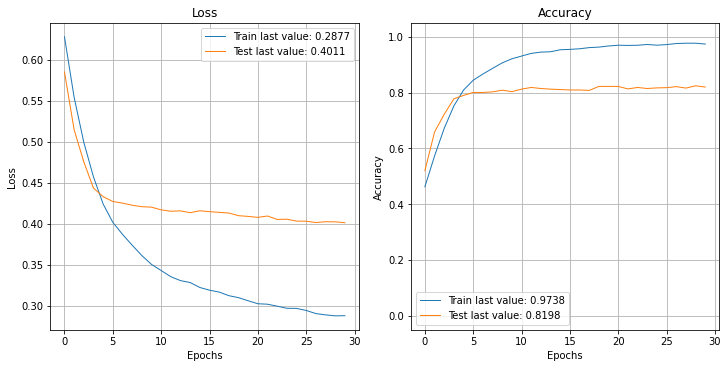

In [ ]:
from plot_keras_history import plot_history
plot_history(history.history, path="std.png")
plt.show()

## Model 3: CNN or LSTM with BERT

Please follow the same methods as model2 to construct a CNN or LSTM model on top of BERT.

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
# your code goes here
import tensorflow as tf

hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_CNN_BERT():
    input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

    bert_embeddings = get_BERT_layer()
    embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
    
    #convolution and pooling layer
    cnn_layer = keras.layers.Conv1D(100, 6)(embedded_sent)
    pooled_sent=GlobalAveragePooling1DMasked()(cnn_layer)

    #two dense layers before the final classifier
    hidden_output=Dense(120,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
    hidden_output2=Dense(hdepth,activation='sigmoid',kernel_initializer='glorot_uniform')(hidden_output) # Sigmoid
    label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output2)
    return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model3_BERT')

use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model3 = create_CNN_BERT()
        optimizer3 = tf.keras.optimizers.Adam(lr=5e-5)
        model3.compile(optimizer=optimizer3, loss='binary_crossentropy', metrics=['accuracy'])
else:
    model3 = create_CNN_BERT()
    model3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model3.summary() 



INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.119.127.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.127.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model3_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_16 (TFDis  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 tilBertModel)                  ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model3.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 109s 3s/step - loss: 0.6209 - accuracy: 0.4610 - val_loss: 0.5890 - val_accuracy: 0.5105
Epoch 2/30
22/22 [==============================] - 5s 212ms/step - loss: 0.5706 - accuracy: 0.5531 - val_loss: 0.5422 - val_accuracy: 0.6569
Epoch 3/30
22/22 [==============================] - 5s 212ms/step - loss: 0.5315 - accuracy: 0.6662 - val_loss: 0.5209 - val_accuracy: 0.6892
Epoch 4/30
22/22 [==============================] - 5s 213ms/step - loss: 0.5094 - accuracy: 0.7025 - val_loss: 0.5044 - val_accuracy: 0.7117
Epoch 5/30
22/22 [==============================] - 5s 212ms/step - loss: 0.4820 - accuracy: 0.7582 - val_loss: 0.4735 - val_accuracy: 0.7718
Epoch 6/30
22/22 [==============================] - 5s 214ms/step - loss: 0.4559 - accuracy: 0.8047 - val_loss: 0.4634 - val_accuracy: 0.7755
Epoch 7/30
22/22 [==============================] - 5s 214ms/step - loss: 0.4331 - accuracy: 0.8436 - val_loss: 0.4507 - val_accuracy: 0.7958
Epoch 8

In [ ]:
results = model3.evaluate([x_test_int_np,x_test_masks_np], y_test)
print(results)

42/42 [==============================] - 8s 105ms/step - loss: 0.3886 - accuracy: 0.8301
[0.38856634497642517, 0.8300898671150208]


<font color = "#5a5f70"><b>The CNN was on par with Model 1 but slightly better than Model 2. However, the loss for CNN model is much less compared to model 1. This is because the CNN concatenates words within a single window as opposed to all the words done by NBOW and assigns equal importance to each word. Although the result keeps fluctuating and the CNN was able to perform better than Model 2 in some cases and model one in all cases.</b></font>

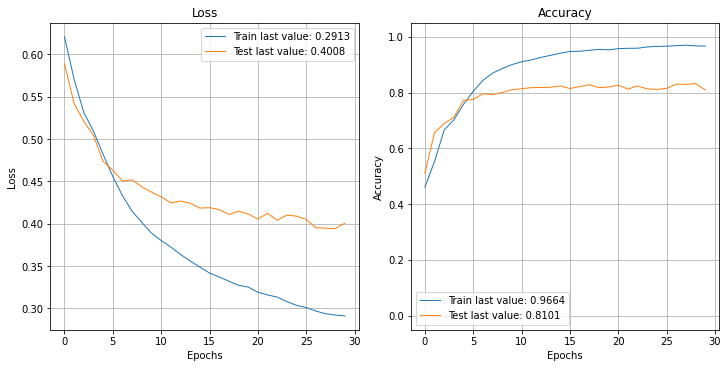

In [ ]:
from plot_keras_history import plot_history
plot_history(history.history, path="std.png")
plt.show()